In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [ ]:
# Cell 1
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence  
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import albumentations as A
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam



from PIL import Image
import random


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.get_logger().setLevel('INFO')

import kagglehub  

path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")
print("Path to dataset files:", path)
data_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'  


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Path to dataset files: /kaggle/input/lgg-mri-segmentation


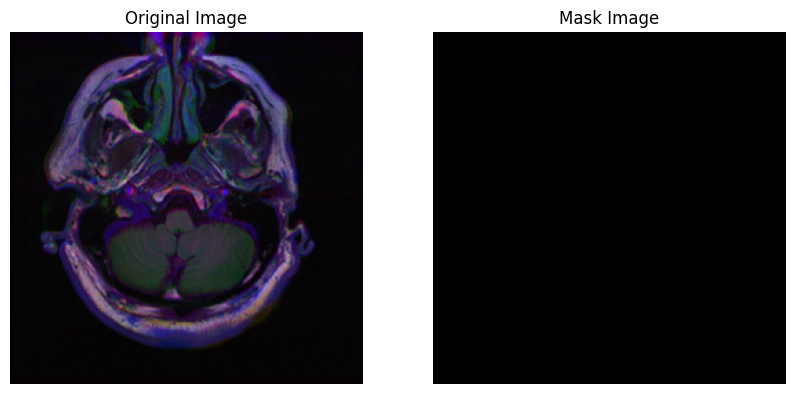

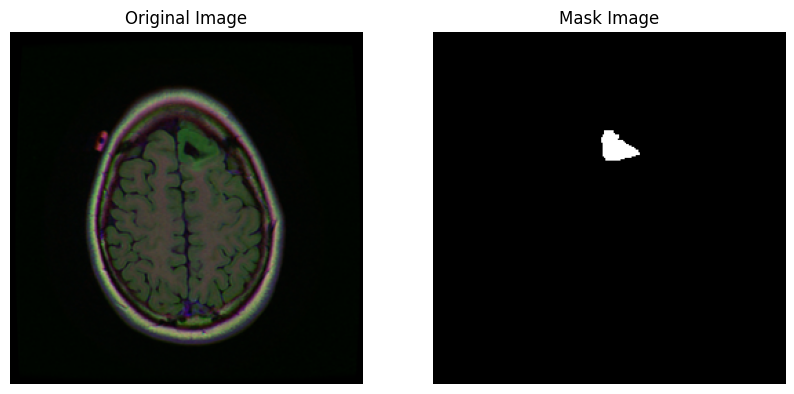

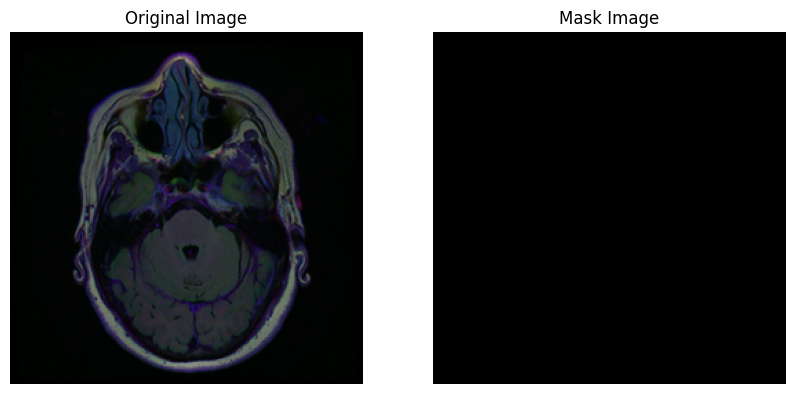

Total samples: 3929
Training samples: 3143
Validation samples: 393
Testing samples: 393


In [ ]:
# Cell 2
data_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

image_paths = glob.glob(os.path.join(data_path, '*', '*[!_mask].tif'))
mask_paths = glob.glob(os.path.join(data_path, '*', '*_mask.tif'))

image_paths.sort()
mask_paths.sort()

sample_indices = random.sample(range(len(image_paths)), 3)
for idx in sample_indices:
    img = plt.imread(image_paths[idx])  
    mask = plt.imread(mask_paths[idx])

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask Image')
    axes[1].axis('off')
    
    plt.show()

data_list = list(zip(image_paths, mask_paths))
train_data, temp_data = train_test_split(data_list, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f'Total samples: {len(data_list)}')
print(f'Training samples: {len(train_data)}')
print(f'Validation samples: {len(val_data)}')
print(f'Testing samples: {len(test_data)}')

/tmp/ipykernel_30/2365764043.py:8: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


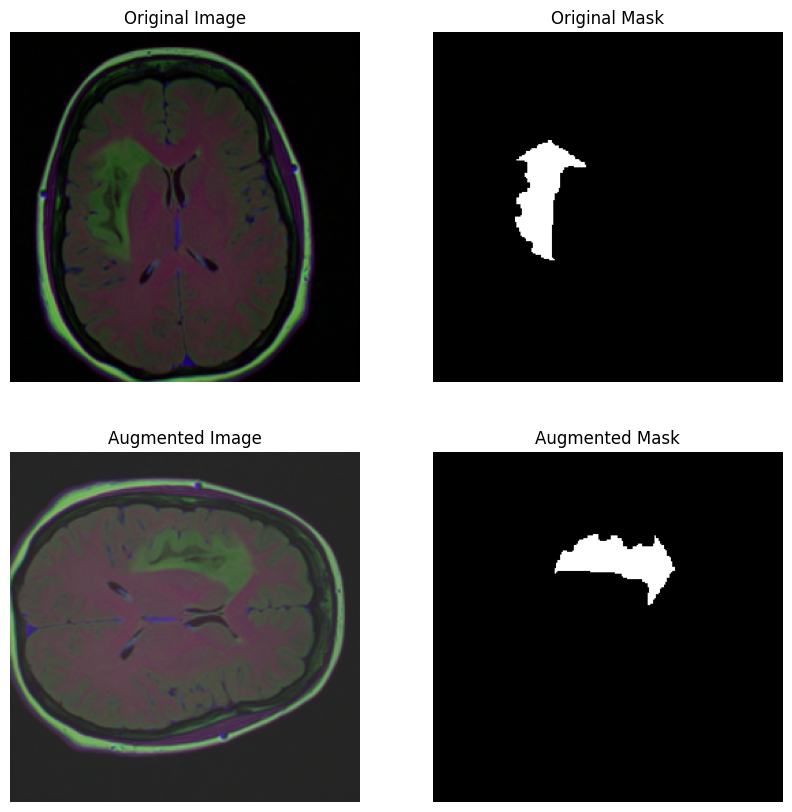

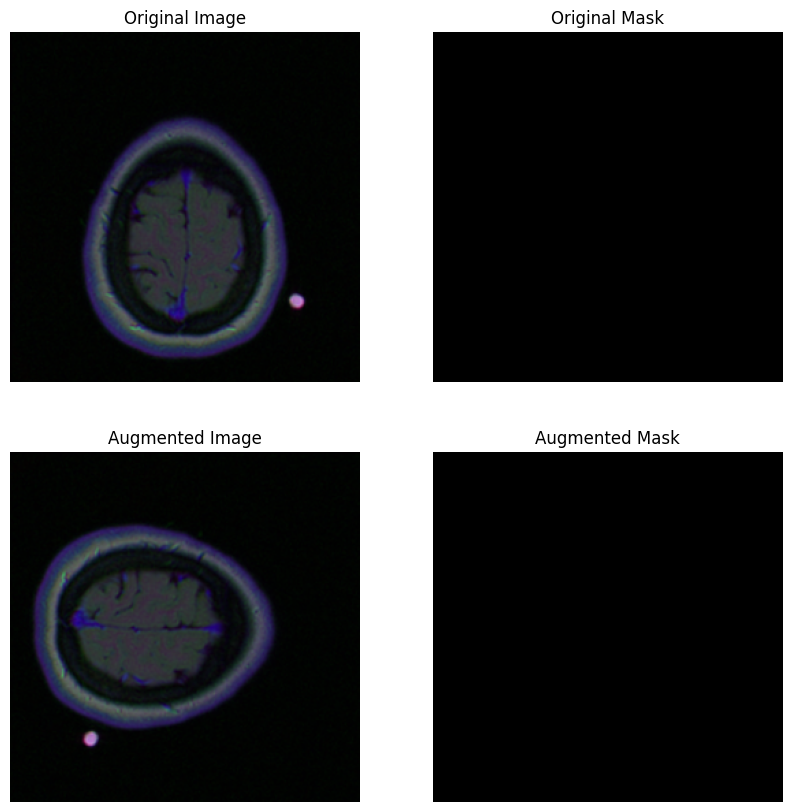

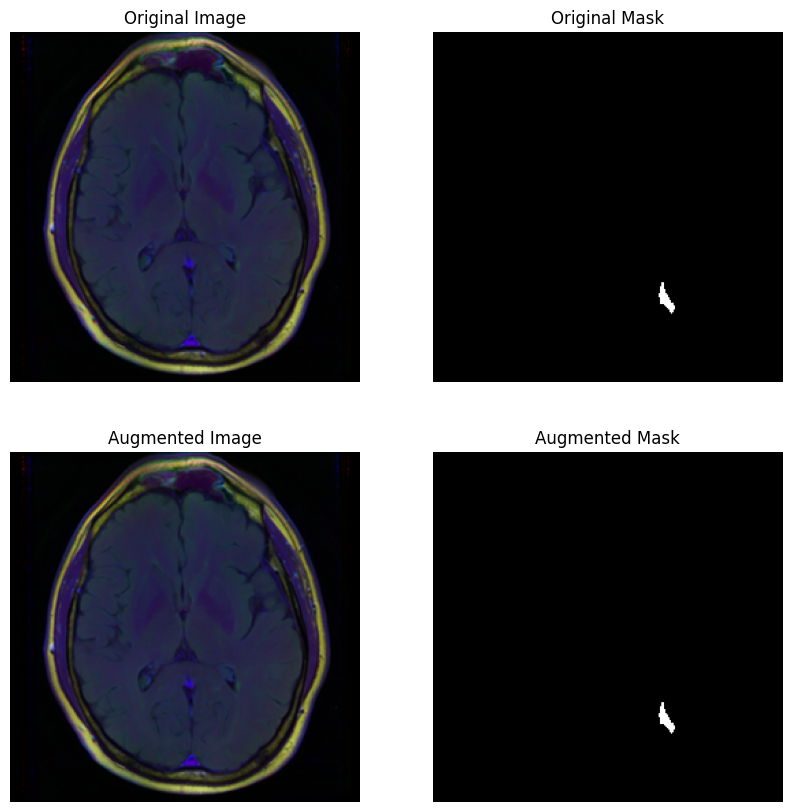

In [ ]:
# Cell 3
import cv2

augmentation = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.2),
])

def augment_sample(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    augmented = augmentation(image=image, mask=mask)
    aug_image = augmented['image']
    aug_mask = augmented['mask']
    
    return aug_image, aug_mask

sample_indices = random.sample(range(len(train_data)), 3)
for idx in sample_indices:
    image_path, mask_path = train_data[idx]
    orig_image = cv2.imread(image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)  
    orig_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    aug_image, aug_mask = augment_sample(image_path, mask_path)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    axes[0, 0].imshow(orig_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(orig_mask, cmap='gray')
    axes[0, 1].set_title('Original Mask')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(aug_image)
    axes[1, 0].set_title('Augmented Image')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(aug_mask, cmap='gray')
    axes[1, 1].set_title('Augmented Mask')
    axes[1, 1].axis('off')
    
    plt.show()

In [ ]:
# Cell 4

import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute the Dice Coefficient.
    Args:
    y_true: True labels.
    y_pred: Predictions.
    smooth: Smoothing factor to avoid division by zero.

    Returns:
    Dice Coefficient as a float between 0 and 1.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1):
    """
    Compute the Intersection over Union (IoU) score.
    Args:
    y_true: True labels.
    y_pred: Predictions.
    smooth: Smoothing factor to avoid division by zero.

    Returns:
    IoU score as a float between 0 and 1.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    """
    Compute Dice Loss, which is 1 minus the Dice Coefficient.
    Used as a loss function for training models.
    Args:
    y_true: True labels.
    y_pred: Predictions.

    Returns:
    Dice Loss as a float.
    """
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
def unet_vgg16(input_size=(256, 256, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)
    
    # Encoder: layers from VGG16
    block1_conv2 = base_model.get_layer('block1_conv2').output
    block2_conv2 = base_model.get_layer('block2_conv2').output
    block3_conv3 = base_model.get_layer('block3_conv3').output
    block4_conv3 = base_model.get_layer('block4_conv3').output
    block5_conv3 = base_model.get_layer('block5_conv3').output
    
    # Decoder: upsampling and concatenating the outputs
    up6 = concatenate([UpSampling2D(size=(2, 2))(block5_conv3), block4_conv3], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), block3_conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), block2_conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), block1_conv2], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=base_model.input, outputs=conv10)
    
    # Freeze the layers of VGG16
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

model = unet_vgg16()

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 21,756,737 (83.00 MB)

 Trainable params: 7,042,049 (26.86 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        print(e)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_coefficient, iou_score, 'accuracy'])

def train_generator(data, batch_size):
    while True:
        batch = np.random.choice(len(data), size=batch_size)
        images = []
        masks = []
        
        for i in batch:
            img_path, mask_path = data[i]
            image, mask = augment_sample(img_path, mask_path)
            images.append(image)
            masks.append(mask)
            
        images = np.array(images, dtype=np.float32)
        masks = np.array(masks, dtype=np.float32)
        
        yield preprocess_input(images), masks / 255.0  

batch_size = 32
epochs = 25

# Creating generators
train_gen = train_generator(train_data, batch_size)
val_gen = train_generator(val_data, batch_size)

# Configure checkpoints and early stopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(train_gen, 
                    steps_per_epoch=len(train_data) // batch_size,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=len(val_data) // batch_size,
                    callbacks=[checkpoint, early_stopping])


2 Physical GPUs, 2 Logical GPU
Epoch 1/25


I0000 00:00:1732461546.248061     130 service.cc:145] XLA service 0x7aab54002900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732461546.248128     130 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732461546.248133     130 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-24 15:19:15.129874: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-24 15:19:15.

98/98 ━━━━━━━━━━━━━━━━━━━━ 170s 918ms/step - accuracy: 0.9818 - dice_coefficient: 0.4209 - iou_score: 0.2816 - loss: 0.5791 - val_accuracy: 0.9922 - val_dice_coefficient: 0.3843 - val_iou_score: 0.2424 - val_loss: 0.6157
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 822ms/step - accuracy: 0.9922 - dice_coefficient: 0.5877 - iou_score: 0.4255 - loss: 0.4123 - val_accuracy: 0.9922 - val_dice_coefficient: 0.5252 - val_iou_score: 0.3693 - val_loss: 0.4748
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 811ms/step - accuracy: 0.9931 - dice_coefficient: 0.6393 - iou_score: 0.4753 - loss: 0.3607 - val_accuracy: 0.9915 - val_dice_coefficient: 0.6233 - val_iou_score: 0.4606 - val_loss: 0.3767
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 797ms/step - accuracy: 0.9931 - dice_coefficient: 0.6422 - iou_score: 0.4814 - loss: 0.3578 - val_accuracy: 0.9914 - val_dice_coefficient: 0.5999 - val_iou_score: 0.4441 - val_loss: 0.4001
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 796ms/step - accuracy: 0.9930 - dice_coeffic

In [ ]:
def test_generator(data, batch_size):
    while True:
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size]
            images = []
            masks = []
            for img_path, mask_path in batch_data:
                image = Image.open(img_path)
                image = np.array(image.resize((256, 256)))  
                mask = Image.open(mask_path)
                mask = np.array(mask.resize((256, 256)))
                images.append(image)
                masks.append(mask)
            
            images = np.array(images, dtype=np.float32)
            masks = np.array(masks, dtype=np.float32)
            yield preprocess_input(images), masks / 255.0

test_gen = test_generator(test_data, batch_size=10)  

results = model.evaluate(test_gen, steps=len(test_data) // 10)
print(f"Test Loss: {results[0]}, Test Dice Coefficient: {results[1]}, Test IoU Score: {results[2]}, Test Accuracy: {results[3]}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.9932 - dice_coefficient: 0.6099 - iou_score: 0.4797 - loss: 0.3901
Test Loss: 0.35822784900665283, Test Dice Coefficient: 0.6417722105979919, Test IoU Score: 0.5104452967643738, Test Accuracy: 0.9939390420913696


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


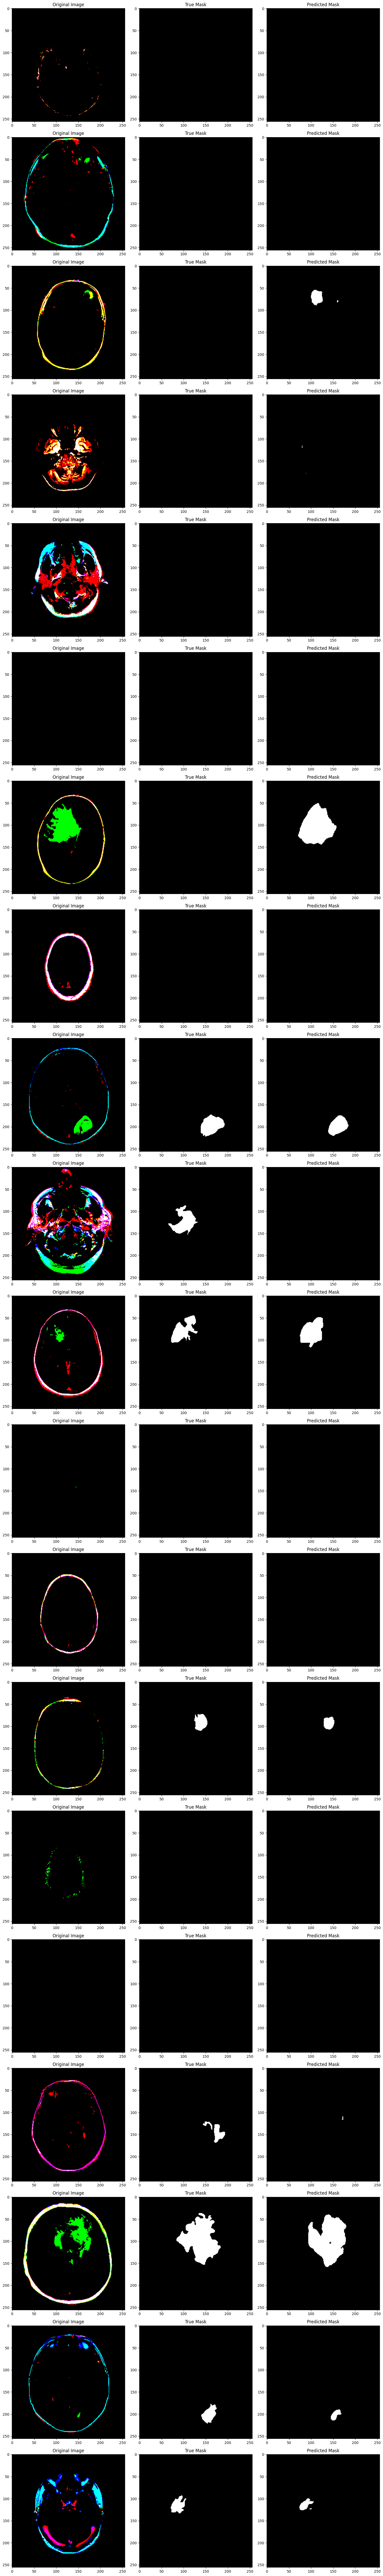

In [ ]:
import matplotlib.pyplot as plt

def show_predictions(data, num_samples=20):  
    batch = next(test_generator(data, batch_size=num_samples))
    images, masks = batch
    preds = model.predict(images)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image')
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

show_predictions(test_data, num_samples=20)


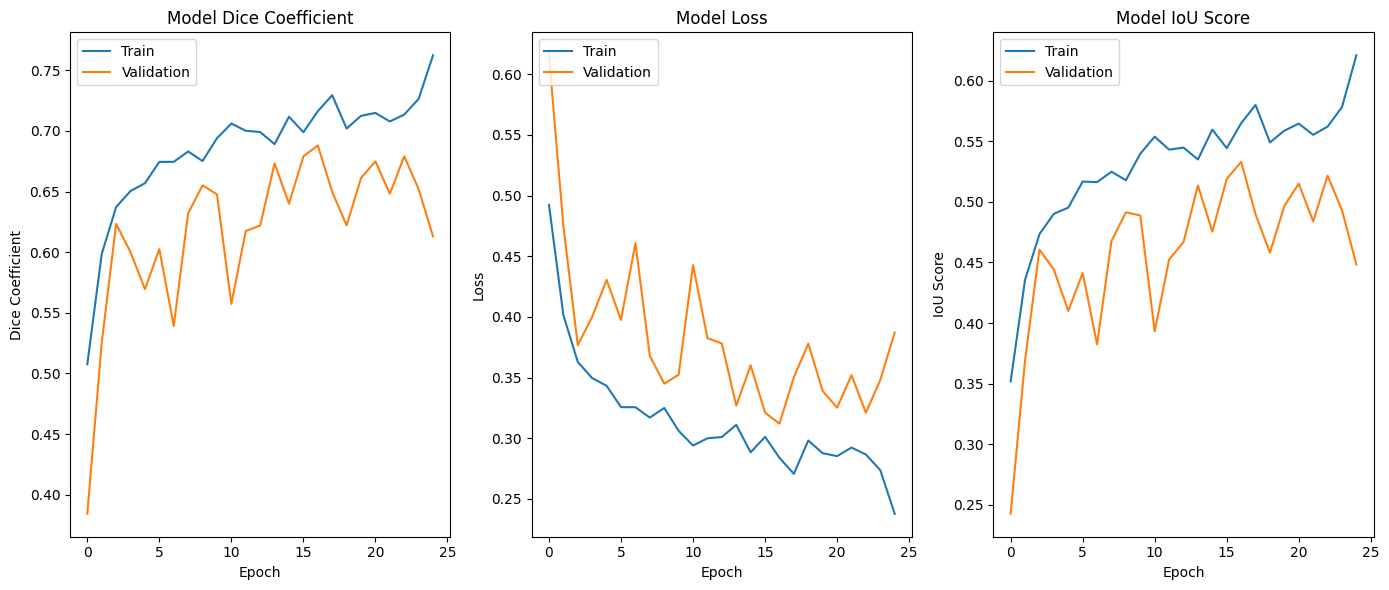

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IoU Score')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


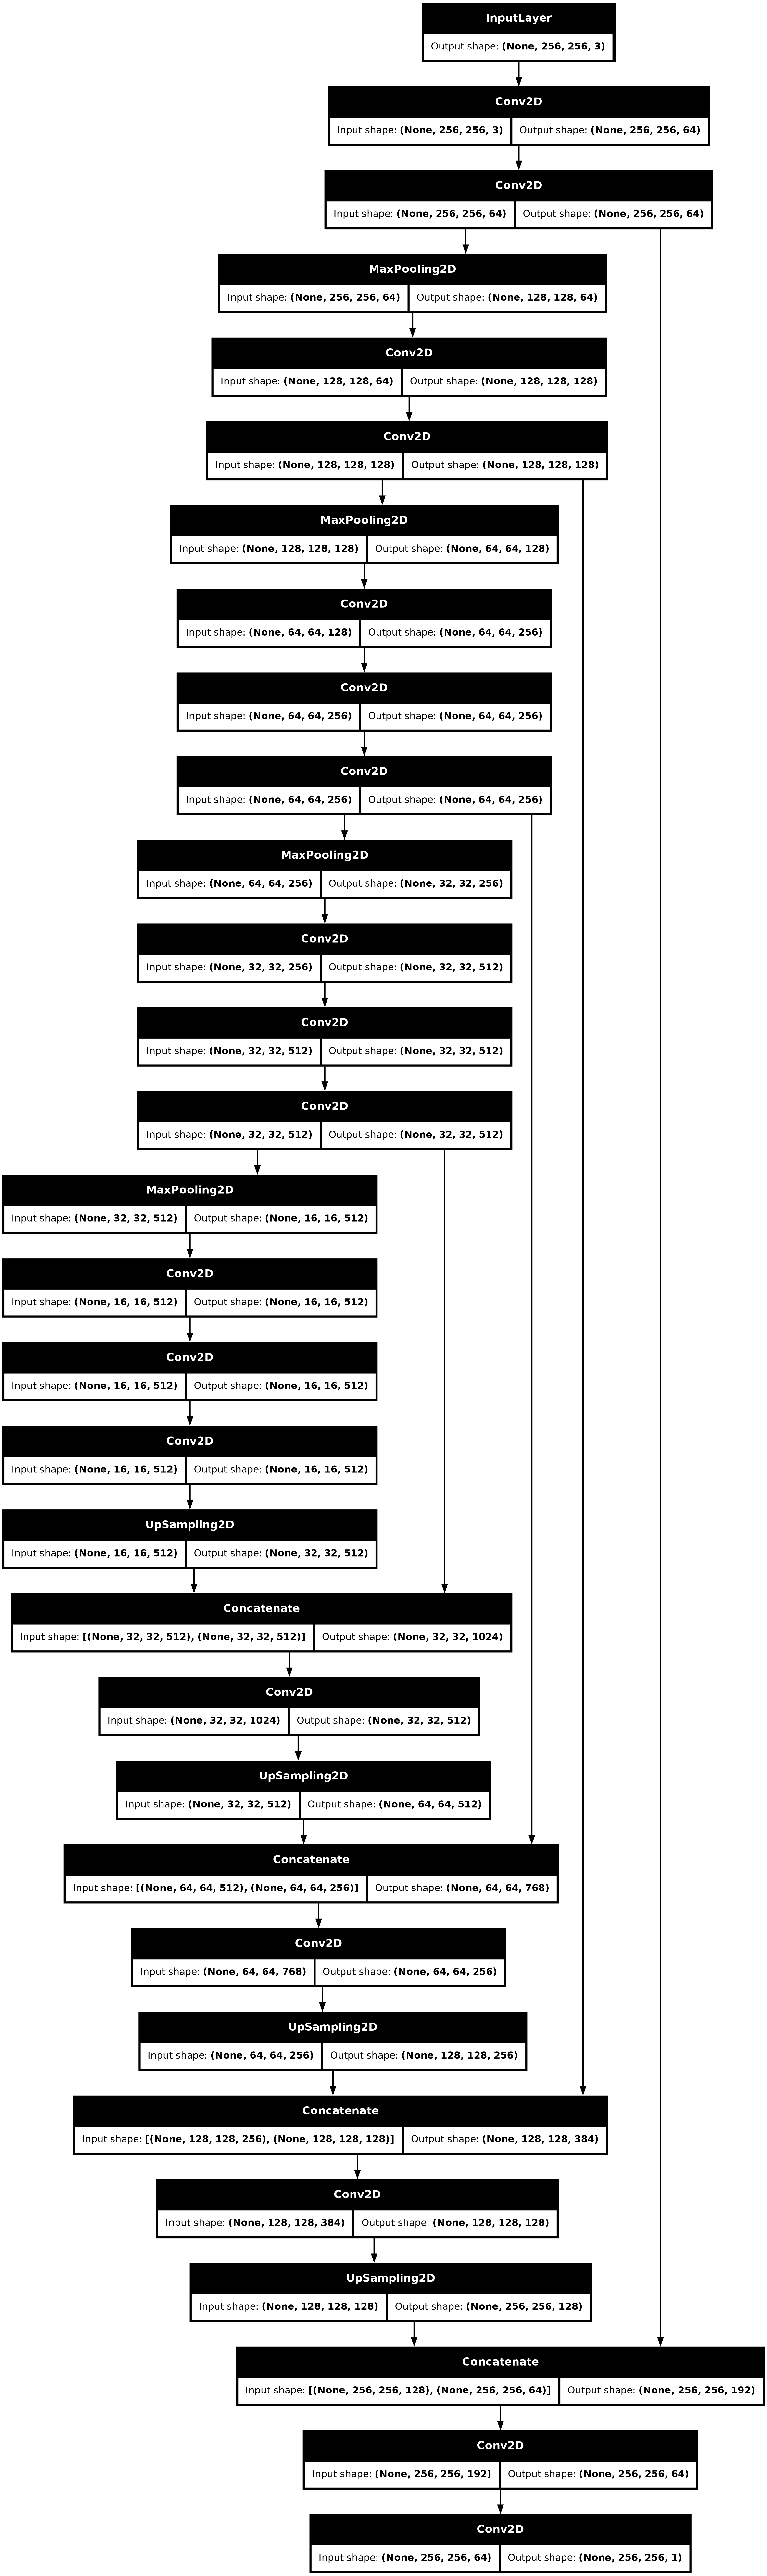

In [15]:
tf.keras.utils.plot_model(model, to_file='unet_vgg16_model.png', show_shapes=True)
